In [24]:
from skimage.io import imread
import numpy as np
from scipy.fftpack import dct, idct
from scipy.signal import convolve2d
from scipy.stats import median_abs_deviation
from matplotlib import pyplot as plt
import time


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Image Processing/lez3_DCT_denoising')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Image Processing/lez3_DCT_denoising'

Definition of dct2 and idct2 (they are not builtin functions)

In [27]:
def dct2(s):
    return dct(dct(s.T, norm='ortho').T, norm='ortho')


def idct2(x):
    return idct(idct(x.T, norm='ortho').T, norm='ortho')

Useful function for plot the 2D DCT dictionary

In [28]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Load the image and rescale it in $[0,1]$

In [29]:
img = imread(f'./data/cameraman.png') / 255
#img = imread(f'./data/checkerboard.png') / 255
# img = np.roll(img, 1, axis=0)
# img = np.roll(img, 1, axis=1)

# img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [30]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(0, sigma_noise, size=imsz)

Compute the psnr of the noisy input

In [31]:
MSE = ((img - noisy_img)**2).mean()
psnr_noisy = 10 * np.log10(1/MSE)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.15')

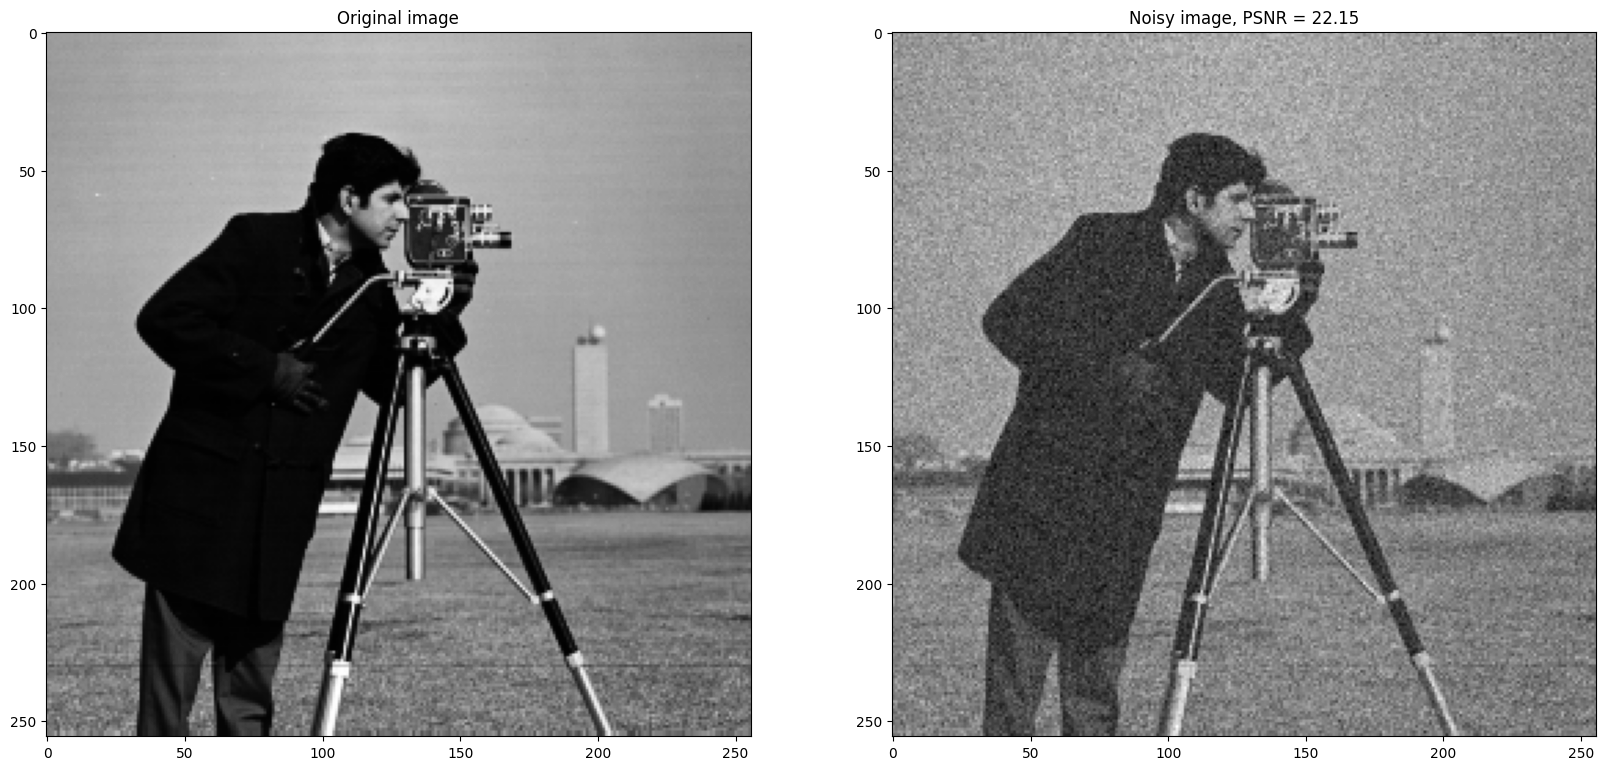

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Denoising by smoothing 
----------------------
Define a filter that by convolution returns the average over a 5x5 region

In [33]:
h = np.ones((5, 5))/25

Compute the convolution of the noisy image against the averaging filter (use the ``convolve2d`` function with the ``same`` padding)

In [34]:
img_hat_conv = convolve2d(noisy_img, h, mode='same')

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image (conv),\nPSNR = 22.09')

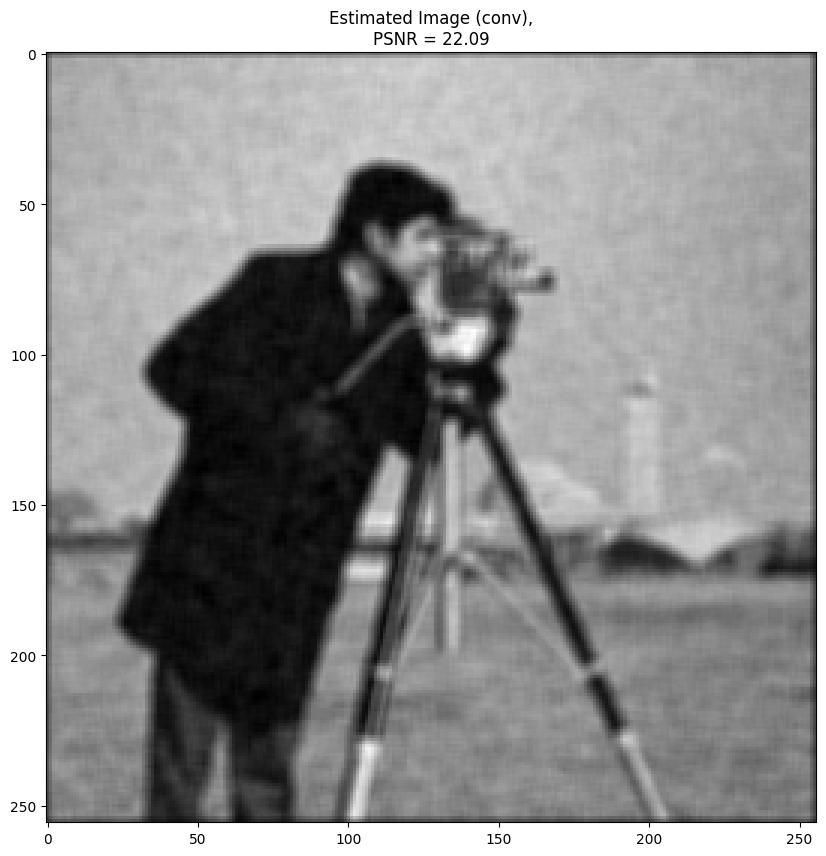

In [35]:
MSE = ((img - img_hat_conv)**2).mean()
psnr_hat_conv = 10 * np.log10(1/MSE)
plt.figure(figsize=(10, 10))
plt.imshow(img_hat_conv, cmap='gray')
plt.title(f'Estimated Image (conv),\nPSNR = {psnr_hat_conv:.2f}')


DCT denoising
-------------
Generate the DCT basis

In [36]:
D = np.zeros((M, M))
cnt = 0
for i in range(p):
    for j in range(p):
        a = np.zeros((p,p))
        a[i,j] = 1
        D[:, cnt] = idct2(a).flatten()
        cnt = cnt + 1


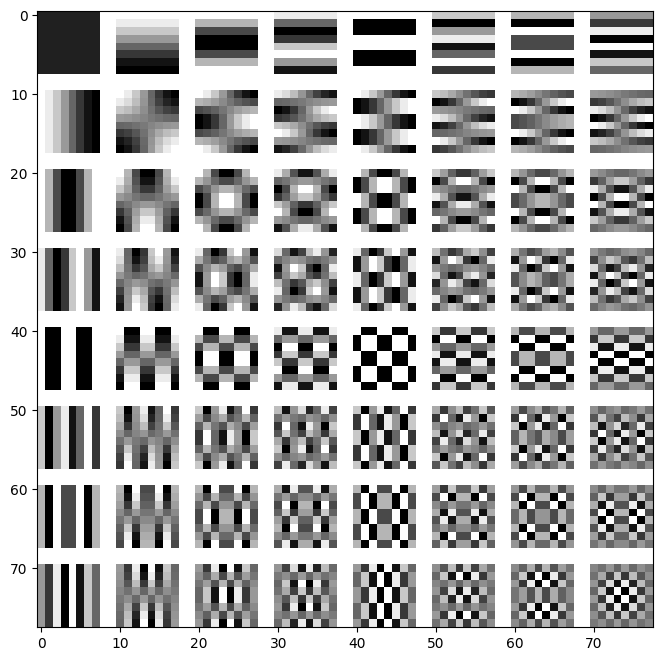

In [37]:
D_img = get_dictionary_img(D)
plt.figure(figsize=(8, 8))
plt.imshow(D_img, cmap='gray')

Denoising: set parameters and initialize the variables

In [38]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise # Donoho says: sigma * sqrt(2*log(p^2))

# define the step (=p for non overlapping paches)
STEP = 1

Perform the denoising pathwise

In [39]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p,j:j+p].flatten()

        # compute the representation w.r.t. the 2D DCT dictionary
        x = np.dot(np.transpose(D), s).reshape((p,p))

        # perform the hard thresholding (do not perform HT on the DC!)
        x_HT = x.copy()
        x_HT[np.abs(x_HT) <= tau] = 0
        x_HT[0,0] = x[0,0]

        # perform the reconstruction
        s_hat = idct2(x_HT)

        # compute the weight for the reconstructed patch
        w = 1/max(1, np.count_nonzero(x_HT))

        # put the compressed patch into the compressed image using the computed weight
        #UPDATE img_hat
        img_hat[i:i+p, j:j+p] += s_hat * w

        # store the weight of the current patch in the weight matrix
        weights[i:i+p, j:j+p] += np.full((p, p), w)

Normalize the estimated image with the computed weights

In [40]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 29.17')

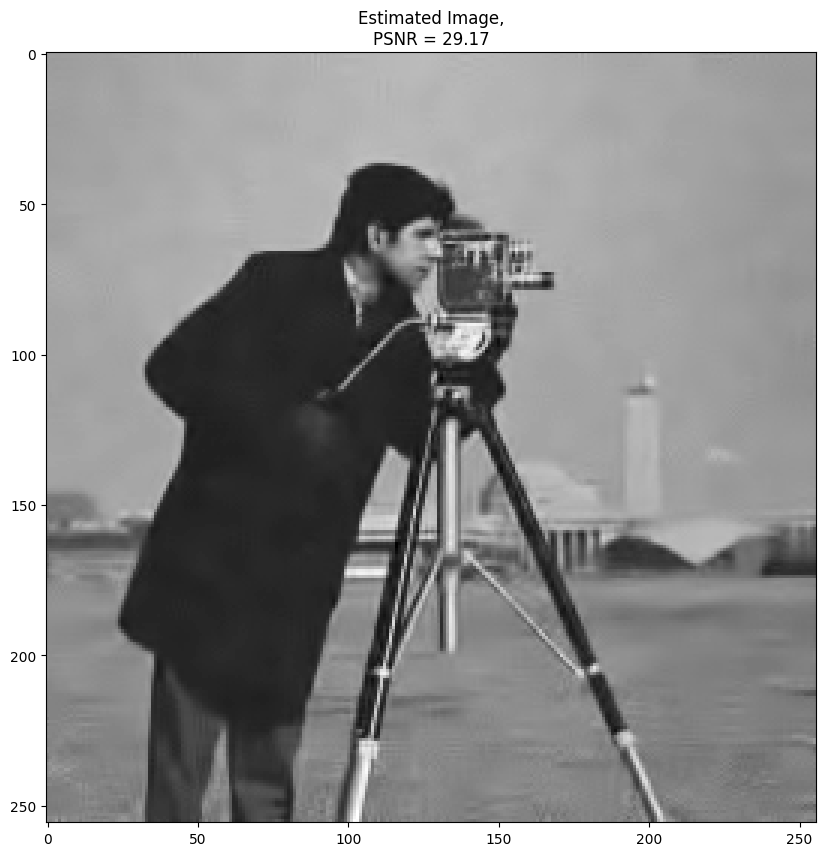

In [41]:
MSE = ((img - img_hat)**2).mean()
psnr_hat = 10 * np.log10(1/MSE)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')

Noise estimation
----------------
Define the horizontal derivative filter

In [42]:
h = np.array([[-1,1]])

Convolve the noisy image and the filter

In [43]:
differences = convolve2d(noisy_img, h, mode='same')

Compute sigma as the empirical std

In [44]:
sigma_hat_emp = np.std(differences) / np.sqrt(2)

Use MAD to estimate the noise level sigma

In [45]:
sigma_hat = median_abs_deviation(differences, axis=None) / (np.sqrt(2) * 0.67449)

In [46]:
print(f'sigma: {sigma_noise:.3f}, sigma_hat (empirical std): {sigma_hat_emp:.3f}, sigma_hat (MAD): {sigma_hat:.3f}')


sigma: 0.078, sigma_hat (empirical std): 0.103, sigma_hat (MAD): 0.087
